---
title: "9.5 Case Study: Information Flow on Social Networks"
subject:  Symmetric Matrices
subtitle: when consensus breaks down
short_title: "9.5 Case Study: Information Flow on Social Networks"
authors:
  - name: Nikolai Matni
    affiliations:
      - Dept. of Electrical and Systems Engineering
      - University of Pennsylvania
    email: nmatni@seas.upenn.edu
license: CC-BY-4.0
keywords: 
math:
  '\vv': '\mathbf{#1}'
  '\bm': '\begin{bmatrix}'
  '\em': '\end{bmatrix}'
  '\R': '\mathbb{R}'
  '\avg': '\mathrm{avg}'
---

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/nikolaimatni/ese-2030/HEAD?labpath=/08_Ch_9_Symmetric_Matrices/106-social-networks.ipynb)

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Learning Objectives

In the previous lectures, we have seen how a simple consensus protocol (averaging your neighbors' values) leads to exponential convergence to the constant vector corresponding to the average value of the initial state $\bold x^\star = \avg(\bold x(0)) \mathbf 1$ on a connected graph. By the end of this case study, you will understand:
* How principles behind consensus can be used to model basic social networks.
* How mild changes to the consensus update lead to different (perhaps undesirable) convergence behaviors.

## Modeling information propagation as consensus

In the previous lecture we saw how to enforce consensus (as measured by every node achieving the same value) via a simple protocol. By modifying the perspective, one can view the consensus protocol itself as a model of information propagation on a network. Recall that the dynamics of the consensus protocol are defined as:
\begin{align}\label{avg}
\dot{x}_i = \sum_{j \in N_i} (x_j - x_i) = -|N_i| (x_i - \text{avg}(x_{N_i})), \qquad \text{(AVG)}
\end{align}
for each node $i =1,\dots,N$. If we view each node as an agent (e.g. person on a social network), consensus can be viewed as a model of how agents interact: in the case of consensus, each agent updates their information via averaging the difference between their neighbors.

As long as the graph (e.g. social network) is connected, we are guaranteed that consensus is reached...assuming that the consensus protocol is a good model of how agents communicate. What happens when we modify the model of communication?

### An experimentalist's friends: random graphs

To experiment with various information propagation models, we need a way to generate graphs synthetically. An oft convenient way to do so is through generating *random graphs*. Roughly speaking, random graphs are generated by connecting edges between vertices according to some distribution. 

One of the most fundamental families of random graphs belongs to the *Erdos-Renyi* model. In the version we consider here, generating an Erdos-Renyi graph takes two parameters: the number of vertices $N$ and a probability $p \in [0,1]$. A sample Erdos-Renyi graph is formed by connecting vertices randomly, where every possible edge *independently* has a probability $p$ of forming. Therefore, $p \approx 0$ likely yields a very sparse graph, whereas $p \approx 1$ likely yields a dense one.

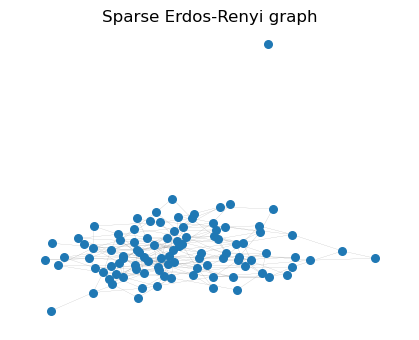

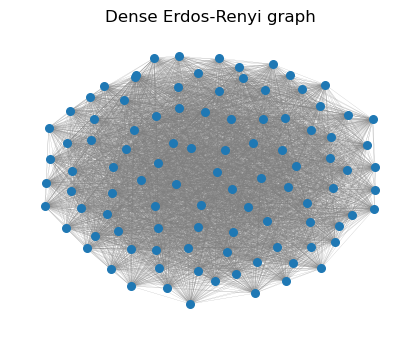

In [2]:
N = 100
p=0.05
G = nx.erdos_renyi_graph(N, p)

# Visualize the graph
plt.figure(figsize=(4, 3))
pos = nx.spring_layout(G)
# colors = ['red' if node < N1 else 'blue' for node in G.nodes()]
nx.draw(G, pos, node_size=30, edge_color='gray', width=0.1)
plt.title("Sparse Erdos-Renyi graph")
plt.show()

N = 100
p=0.9
G = nx.erdos_renyi_graph(N, p)

# Visualize the graph
plt.figure(figsize=(4, 3))
pos = nx.spring_layout(G)
# colors = ['red' if node < N1 else 'blue' for node in G.nodes()]
nx.draw(G, pos, node_size=30, edge_color='gray', width=0.1)
plt.title("Dense Erdos-Renyi graph")
plt.show()

With an easy way to generate graphs at hand, let us now consider the communication model. In the original consensus model, we assumed that each agent updates their beliefs by treating the beliefs of their neighbors with equal weight.  Instead of equal weight, we can instead assign different weights to each neighbor:
\begin{align}
\dot{x}_i = \sum_{j \in N_i} w_j (x_j - x_i), \quad\text{where } \sum_{j \in N_i} w_j = |N_i|.
\end{align}
Observe that setting each $w_j = 1$ recovers the original consensus model. What could these weights look like? In reality, we might expect that agents are not equally receptive to neighbors that are radically different, and thus put more weight on neighbors that are more similar to themselves. There are various ways to encode this. For example, let $B>0$ be a fixed upper bound that satisfies $x_i\leq B$ for all $i=1,\dots,N$ (we assume $\bold x(0) \geq 0$). Then, we can define:
\begin{align*}
w_j = |N_i| \frac{B - |x_j-x_i|}{\sum_{k \in N_i} B - |x_j-x_i|}, \quad \text{such that }\sum_{j \in N_i} w_j = |N_i|.
\end{align*}
Therefore, the closer $x_j$ is to $x_i$, the larger $w_j$ is relatively. Another possiblity is:
\begin{align*}
w_j = |N_i| \frac{\exp(-|x_j-x_i|)}{\sum_{k \in N_i} \exp(-|x_j-x_i|)}, \quad \text{such that }\sum_{j \in N_i} w_j = |N_i|,
\end{align*}
where we observe that as $x_j$ gets further from $x_i$ its relative weight decreases *exponentially*. This is analogous the the "min" version of the [$\mathrm{Softmax}$ function](../02_Ch_3_Inner_Products_and_Norms/042a-NLP-case-study.ipynb#softmax-def) discussed all the way back in [Case Study 3.3](../02_Ch_3_Inner_Products_and_Norms/042a-NLP-case-study.ipynb). We note that the weighting effect can be exaggerated through instead computing 
\begin{align*}
w_j = |N_i| \frac{\exp(-\beta |x_j-x_i|)}{\sum_{k \in N_i} \exp(-\beta |x_j-x_i|)}, \quad \text{such that }\sum_{j \in N_i} w_j = |N_i|,
\end{align*}
for a parameter $\beta \geq 1$.

Before deploying these new communication protocols, how do we actually implement the continuous-time differential equation governing $\dot {\bold x}$? For the standard consensus protocol, we were able to analytically solve the *ordinary differential equation*. However, with these new weighting schemes, the resulting differential equation is not as straightforward to solve. Fortunately, it suffices for us to approximate the differential equation via discretization. In particular, given a sufficiently small timestep $\Delta > 0$, we observe
\begin{align*}
    &\bold x(t+\Delta) - \bold x(t) \approx \Delta \dot{\bold x}(t) \\
    \implies \;& \bold x(t+\Delta) \approx \bold x(t) + \Delta \dot{\bold x}(t).
\end{align*}

Let's try these modified protocols on Erdos-Renyi graphs.

In [3]:
def update_x(G, x, weight=False, delta_t=0.01, beta=1):
    x_next = x.copy()
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        if neighbors:
            neighbor_x = x[neighbors]
            if weight:
                # Choice of either weighting scheme
                # weights = np.maximum(1 - np.abs(x[node] - neighbor_x), np.zeros_like(neighbor_x))
                weights = np.exp(-beta*np.abs(x[node]-neighbor_x))
                weights = (weights / np.sum(weights))*len(neighbor_x)
                update = np.sum(weights * (neighbor_x - x[node]))
            else:
                update = np.sum(neighbor_x - x[node])
            # Update x_i using discretized diffeq
            x_next[node] += delta_t * update
    return x_next

def plotting(x_init, x_final, x_history, num_steps, delta_t, final_xlim=True, show_dist=True):
    fig = plt.figure(figsize=(10,3))
    
    ax1 = fig.add_subplot(121)
    sns.histplot(x_init, bins=25, kde=True)
    ax1.set_xlabel("Value of x_i")
    ax1.set_ylabel("Frequency")
    ax1.set_title("Initial Distribution")
    
    ax2 = fig.add_subplot(122)
    sns.histplot(x, bins=25, kde=True)
    if final_xlim:
        ax2.set_xlim([0,1])
    ax2.set_xlabel("Value of x_i")
    ax2.set_ylabel("Frequency")
    ax2.set_title("Final Distribution")
    plt.show()
    
    if show_dist:
        # Plot value evolution
        plt.figure(figsize=(5, 3))
        # x_history_array = np.array(x_history)
        for i in range(0, num_steps + 1, int(num_steps/10)):  # Plot every 10th step
            sns.kdeplot(x_history[i], label=f"Time={i*int(num_steps/10)*delta_t}")
        plt.xlabel("Value")
        plt.ylabel("Density")
        plt.yscale('log')
        plt.title("Distribution Change Over Time")
        plt.legend()
        plt.show()

Avg(x(0)) = 0.507
Avg(x(T)) = 0.505


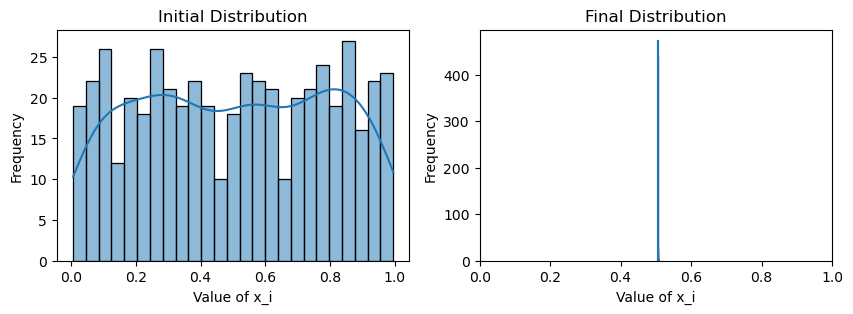

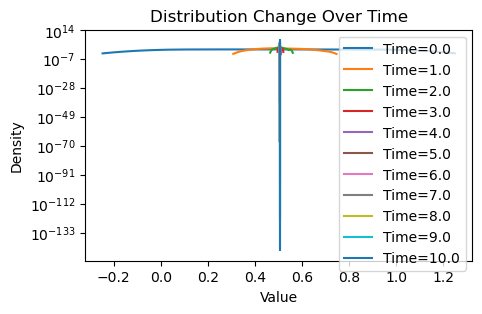

In [4]:
# Create Erdos Renyi graph
N = 500
p=0.05
G = nx.erdos_renyi_graph(N, p)
x_init = np.random.uniform(0, 1, N)

# Simulate information dynamics
num_steps = 100
x_history = [x_init.copy()]

x = x_init.copy()
delta_t = 0.01
for i in range(num_steps):
    x = update_x(G, x, weight=True, delta_t=delta_t, beta=3)
    x_history.append(x.copy())
    
print(f"Avg(x(0)) = {np.mean(x_init):.3f}")
print(f"Avg(x(T)) = {np.mean(x):.3f}")

plotting(x_init, x, x_history, num_steps, delta_t)

Now let's benchmark against the original consensus protocol:

Avg(x(0)) = 0.507
Avg(x(T)) = 0.507


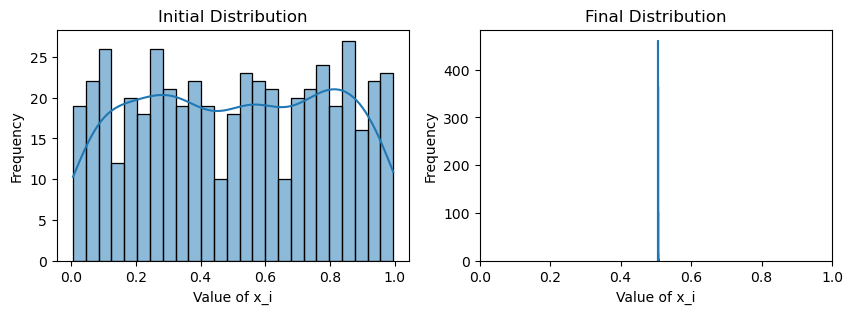

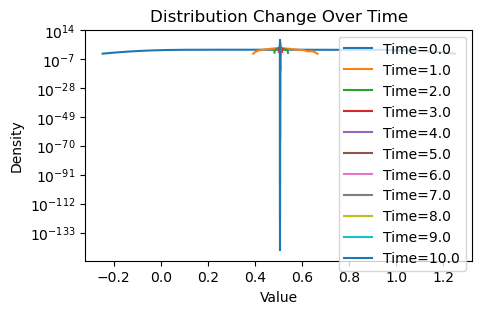

In [5]:
x_history = [x_init.copy()]

x = x_init.copy()
delta_t = 0.01
for i in range(num_steps):
    x = update_x(G, x, weight=False, delta_t=delta_t)
    x_history.append(x.copy())
    
print(f"Avg(x(0)) = {np.mean(x_init):.3f}")
print(f"Avg(x(T)) = {np.mean(x):.3f}")

plotting(x_init, x, x_history, num_steps, delta_t)

Well, that is rather uninspiring. Despite the new weighting scheme, it seems that we are achieving the same thing as the original consensus protocol: the initial and final average values are essentially the same for both, and there is no variance in the values of $\bold x$ by the end, meaning that both schemes have converged.

However, is this really surprising? We note that by nature of Erdos-Renyi graph, any edge has an equal probability of being formed. Therefore, it is very unlikely that communities form within an Erdos-Renyi graph, i.e. subgraphs that are well-connected within but sparsely connected to outside vertices. Therefore, though we may have biased which nodes are more highly weighted in the consensus, causing nodes to average faster to neighbors close in value, eventually we will be left with nodes that are far in value. This eventually drives the nodes to $\mathrm{avg}(\bold x(0))$. A good sanity check would be to imagine half the nodes started with value exactly $0$, and the other half $1$.

This implies Erdos-Renyi graphs are a poor choice if we want to test the effect of weighted averaging, since all nodes are basically in same big community. Therefore, this implies we should look for a more specific family of graphs that would serve as a better model of how communities and "confirmation bias" interact. Enter the **stochastic block model**.

### Communities and Echo Chambers: Stochastic Block Models

Stochastic block models (SBM) are a family of random graphs that are essentially communities Erdos-Renyi graphs that are interconnected with some (usually small) probability. Sampling an (undirected) SBM takes the following parameters:
* The number of vertices $N$.
* The number of communities $k$.
* The indices of verties belonging to each community $V_1,\dots, V_k$.
* A symmetric matrix of probabilities $P$, where $p_{ij}$ is the probability that a randomly sampled edge between $V_i$ and $V_j$ is formed (such that $p_{ii}$ is the probability that an edge forms within $V_i$).

Therefore, we can step up our simulation of social networks through this model by imagining agents are highly interconnected in their own communities, but different communities are only sparsely interconnected. We can try our communication protocols on a 2-community SBM. Furthermore, we will initialize the values on $V_1$ as a normal distribution with mean $0$ and standard deviation $0.25$, and $V_2$ with mean $1$ and standard deviation $0.25$.

Within-community edge probability: 0.1
Between-community edge probability: 0.001


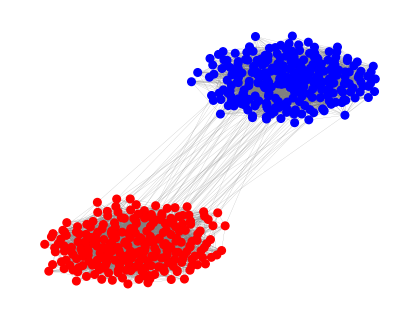

Weighted consensus
Avg(x(0)) = 0.509
Avg(x(T)) = 0.508


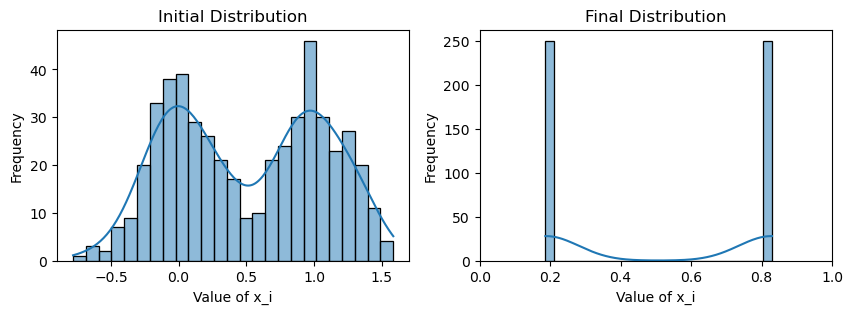

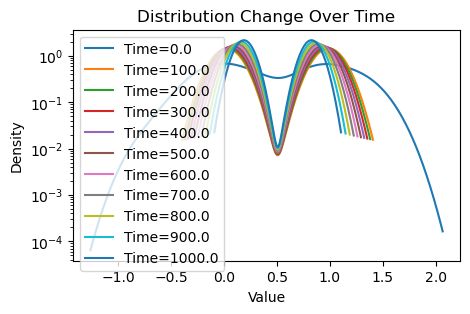

In [6]:
def create_SBM(n1, n2, p_within, p_between):
    sizes = [n1, n2]
    probs = [[p_within, p_between],
             [p_between, p_within]]
    G = nx.stochastic_block_model(sizes, probs, directed=False)
    return G

# Create the graph
N1, N2 = 250, 250  # Size of each community
p_within = 0.1     # High probability of connection within community
p_between = 0.001  # Low probability of connection between communities
print(f"Within-community edge probability: {p_within}")
print(f"Between-community edge probability: {p_between}")

G = create_SBM(N1, N2, p_within, p_between)
# Visualize the graph
plt.figure(figsize=(4, 3))
pos = nx.spring_layout(G)
colors = ['red' if node < N1 else 'blue' for node in G.nodes()]
nx.draw(G, pos, node_color=colors, node_size=30, edge_color='gray', width=0.1)
plt.show()

x_init = np.zeros(N1+N2)
x_init[:N1] = np.random.normal(0, 0.25, N1)
x_init[N1:] = np.random.normal(1, 0.25, N2)

# Simulate information dynamics
num_steps = 1000
x_history = [x_init.copy()]
x = x_init.copy()
delta_t = 0.01
for i in range(num_steps):
    x = update_x(G, x, weight=True, delta_t=delta_t, beta=3)
    x_history.append(x.copy())

print("Weighted consensus")
print(f"Avg(x(0)) = {np.mean(x_init):.3f}")
print(f"Avg(x(T)) = {np.mean(x):.3f}")

plotting(x_init, x, x_history, num_steps, delta_t)

Original consensus
Avg(x(0)) = 0.509
Avg(x(T)) = 0.509


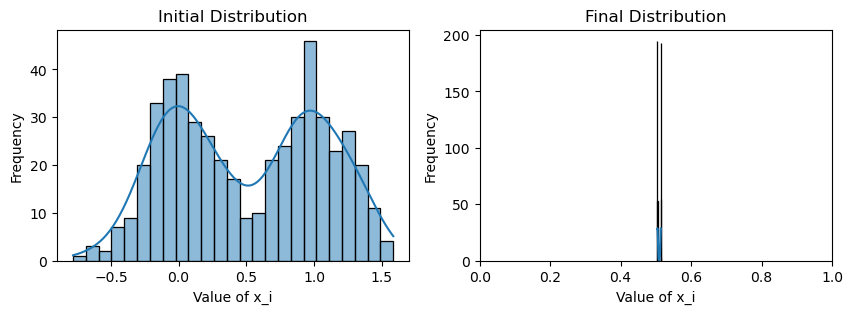

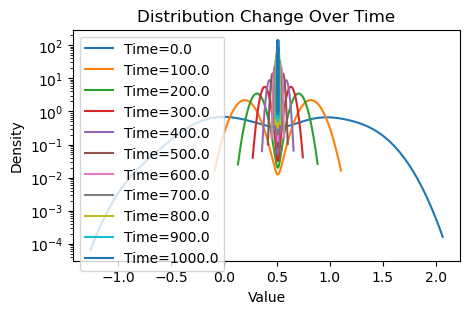

In [7]:
# Simulate information dynamics
num_steps = 1000
x_history = [x_init.copy()]
x = x_init.copy()
delta_t = 0.01
for i in range(num_steps):
    x = update_x(G, x, weight=False, delta_t=delta_t, beta=3)
    x_history.append(x.copy())
    
print("Original consensus")
print(f"Avg(x(0)) = {np.mean(x_init):.3f}")
print(f"Avg(x(T)) = {np.mean(x):.3f}")

plotting(x_init, x, x_history, num_steps, delta_t)

Now that this is a lot more dramatic! Since there are relatively few edges traversing between the two communities, consensus is much slower with the weighting scheme: each community reaches the average of their values very quickly, but information from the other community must trickle slowly through the few between-edges, further hampered by the confirmation bias of the community.

However, we see that consensus is still eventually reached by running more for our simulation for longer, since the magnetism between communities, despite weak will still eventually attract the two communities.

Weighted consensus 1000->5000 timesteps
Avg(x(0)) = 0.509
Avg(x(T)) = 0.508


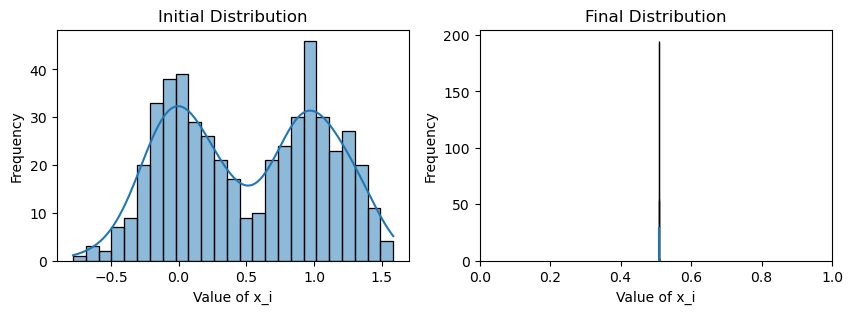

In [8]:
# Simulate information dynamics
num_steps = 5000
x_history = [x_init.copy()]
x = x_init.copy()
delta_t = 0.01
for i in range(num_steps):
    x = update_x(G, x, weight=True, delta_t=delta_t, beta=3)
    x_history.append(x.copy())

print("Weighted consensus 1000->5000 timesteps")
print(f"Avg(x(0)) = {np.mean(x_init):.3f}")
print(f"Avg(x(T)) = {np.mean(x):.3f}")

plotting(x_init, x, x_history, num_steps, delta_t, show_dist=False)

However, what happens when there are a small number of extremely stubborn agents (or even bad actors) in both communities that never change their values? How close do we still get to consensus? Let us introduce just 3 bad nodes per community (out of 250) that maintain their values at 0 and 1, respectively.

Weighted consensus
Avg(x(0)) = 0.509
Avg(x(T)) = 0.511
Avg(x(T)) of community 1 = 0.084
Avg(x(T)) of community 2 = 0.938


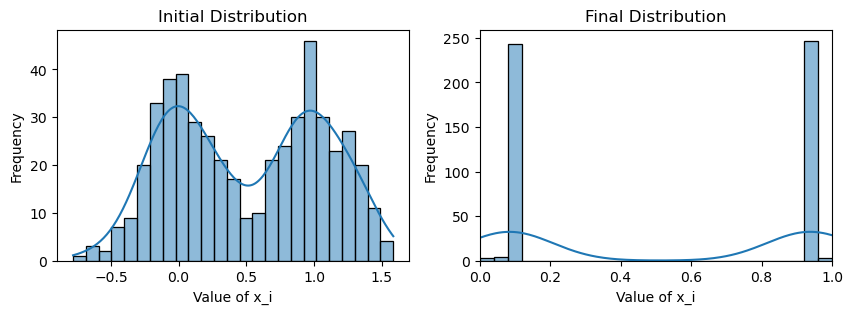

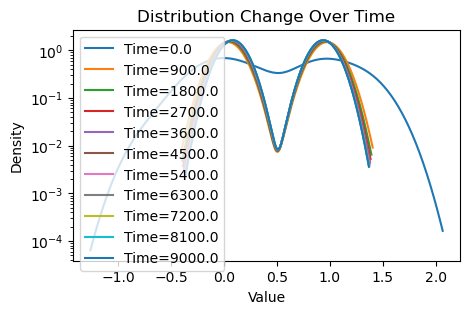

In [9]:
# Simulate information dynamics
num_steps = 3000
num_bad = 3
x_history = [x_init.copy()]
x = x_init.copy()
delta_t = 0.01
for i in range(num_steps):
    x = update_x(G, x, weight=True, delta_t=delta_t, beta=3)
    # bad actors don't change values
    x[:num_bad] = 0
    x[-num_bad:] = 1
    x_history.append(x.copy())

print("Weighted consensus")
print(f"Avg(x(0)) = {np.mean(x_init):.3f}")
print(f"Avg(x(T)) = {np.mean(x):.3f}")
print(f"Avg(x(T)) of community 1 = {np.mean(x[:N1]):.3f}")
print(f"Avg(x(T)) of community 2 = {np.mean(x[N1:]):.3f}")

plotting(x_init, x, x_history, num_steps, delta_t)

Original consensus
Avg(x(0)) = 0.509
Avg(x(T)) = 0.543
Avg(x(T)) of community 1 = 0.355
Avg(x(T)) of community 2 = 0.731


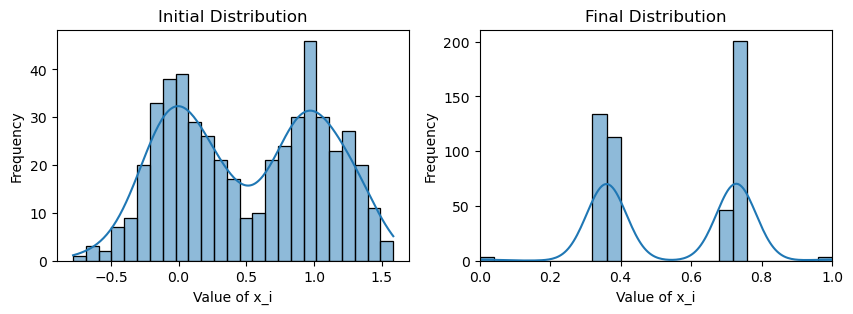

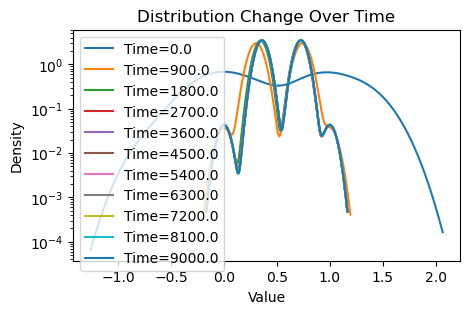

In [10]:
# Simulate information dynamics
num_steps = 3000
num_bad = 3
x_history = [x_init.copy()]
x = x_init.copy()
delta_t = 0.01
for i in range(num_steps):
    x = update_x(G, x, weight=False, delta_t=delta_t, beta=3)
    # bad actors don't change values
    x[:num_bad] = 0
    x[-num_bad:] = 1
    x_history.append(x.copy())
    
print("Original consensus")
print(f"Avg(x(0)) = {np.mean(x_init):.3f}")
print(f"Avg(x(T)) = {np.mean(x):.3f}")
print(f"Avg(x(T)) of community 1 = {np.mean(x[:N1]):.3f}")
print(f"Avg(x(T)) of community 2 = {np.mean(x[N1:]):.3f}")

plotting(x_init, x, x_history, num_steps, delta_t)

We see that both consensus protocols are affected, but this time the weighted consensus scheme suffers disproportionately compared to the standard consensus scheme. Whereas both communities under standard consensus has drifted nontrivially toward the true mean, under weighted consensus both communities have barely shifted past their respective initial means of $0$ and $1$.

This highlights how one can arbitrarily slow down or prevent consensus in graphs with community structure with just a couple of bad actors, due to how disproportionately quickly information propagates *within* a community compared to *between communities*. Despite our simplistic graph models, these principles have tangible impacts in social networks, and mitigating the associated pathologies remains a critical problem (see e.g. [astroturfing](https://en.wikipedia.org/wiki/Astroturfing)).